In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np

from deepr import DeepR

from trainer import trainer, test_stats

import pickle

DTYPE=torch.float
torch.manual_seed(734)
print("Feedforward ANN Trained on MNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#print('Using device:', device)


# Training Parameters
batch_size=128 # big batch size needed otherwise training loss histogram is noisy; helps with deepr aswell
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

# mnist_train = datasets.MNIST(root = './', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root = './', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True,drop_last=True)

############ MNIST Model ################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 300   
num_hidden2 = 100
num_outputs = 10

lr=1e-2 #TODO learning rate does not directly translate from the SNN model due to the iteration steps for producing spikes
#weight_decay=1e-6

class Net(nn.Module):

    def __init__(self,connectivity):
        super().__init__()

        self.loss = nn.CrossEntropyLoss()
        self.accuracy_metric = lambda logits, targets: (torch.argmax(logits,dim=1) == targets).sum().item() / targets.size(0)

        self.linears = nn.ModuleList([
            nn.Linear(num_inputs, num_hidden1),
            nn.Linear(num_hidden1, num_hidden2),
            nn.Linear(num_hidden2, num_outputs)
        ])

        

        self.neurons = nn.ModuleList([
            nn.ReLU(),
            nn.ReLU(),
            nn.ReLU()
        ])

        self.to(device)
        self.deepr = DeepR(self.linears,lr,connectivity=connectivity,device=device)
        
    def forward(self,x):
        x=x.view(x.size(0), -1)
        
        x = self.linears[0](x)
        x = self.neurons[0](x)
        x = self.linears[1](x)
        x = self.neurons[1](x)
        x = self.linears[2](x)

        return x

d:\Program Files\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Feedforward ANN Trained on MNIST


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.14
Validation accuracy: 25.78%
Training accuracy: 8.59%
----------------
Iteration: 50
Training loss: 0.31
Validation loss: 0.30
Validation accuracy: 89.06%
Training accuracy: 88.28%
----------------
Iteration: 100
Training loss: 0.18
Validation loss: 0.15
Validation accuracy: 95.31%
Training accuracy: 95.31%
----------------
Iteration: 150
Training loss: 0.21
Validation loss: 0.18
Validation accuracy: 94.53%
Training accuracy: 91.41%
----------------
Iteration: 200
Training loss: 0.15
Validation loss: 0.19
Validation accuracy: 93.75%
Training accuracy: 95.31%
----------------
Iteration: 250
Training loss: 0.12
Validation loss: 0.16
Validation accuracy: 95.31%
Training accuracy: 98.44%
----------------
Iteration: 300
Training loss: 0.20
Validation loss: 0.12
Validation accuracy: 96.09%
Training accuracy: 92.97%
----------------
Iteration: 350
Training loss: 0.15
Validation loss: 0.16
Validation accuracy: 93.75%
Training accuracy: 95.3

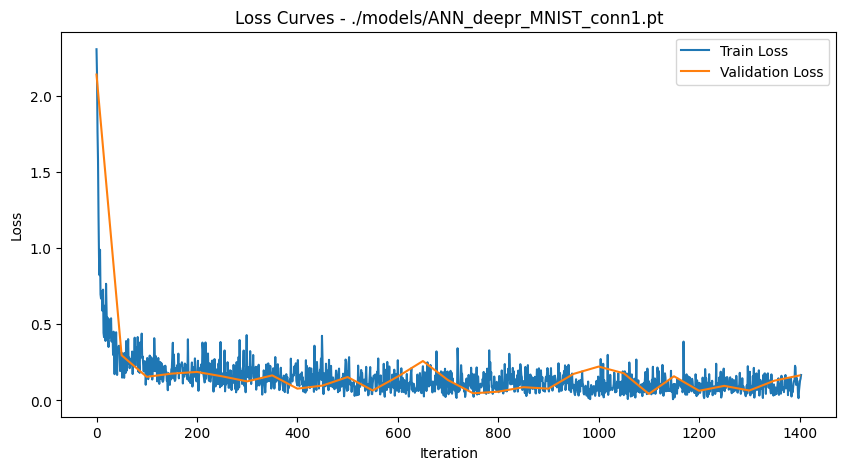

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 96.84%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.29
Validation loss: 2.26
Validation accuracy: 14.84%
Training accuracy: 14.06%
----------------
Iteration: 50
Training loss: 0.19
Validation loss: 0.26
Validation accuracy: 89.06%
Training accuracy: 93.75%
----------------
Iteration: 100
Training loss: 0.35
Validation loss: 0.18
Validation accuracy: 92.97%
Training accuracy: 89.06%
----------------
Iteration: 150
Training loss: 0.18
Validation loss: 0.24
Validation accuracy: 94.53%
Training accuracy: 92.97%
----------------
Iteration: 200
Training loss: 0.12
Validation loss: 0.19
Validation accuracy: 93.75%
Training accuracy: 97.66%
----------------
Iteration: 250
Training loss: 0.27
Validation loss: 0.14
Validation accuracy: 96.88%
Training accuracy: 92.97%
----------------
Iteration: 300
Training loss: 0.11
Validation loss: 0.16
Validation accuracy: 95.31%
Training accuracy: 96.09%
----------------
Iteration: 350
Training loss: 0.12
Validation loss: 0.16
Validation accuracy: 92.97%
Training accuracy: 95.

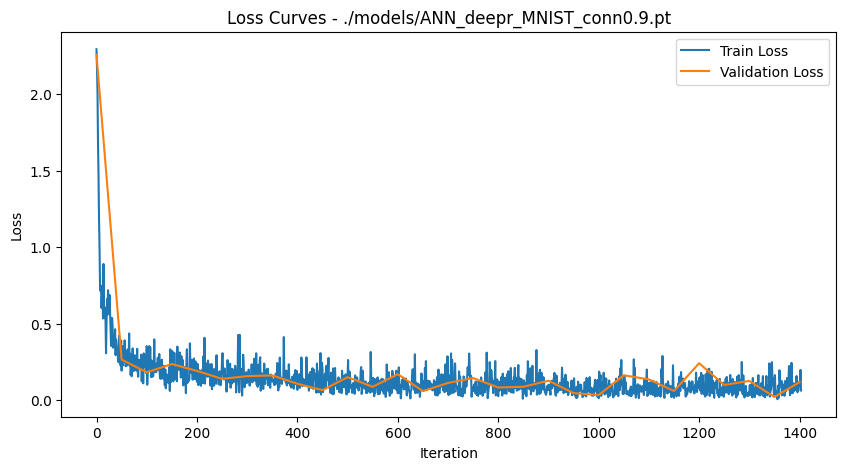

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 97.23%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.31
Validation loss: 2.23
Validation accuracy: 21.09%
Training accuracy: 5.47%
----------------
Iteration: 50
Training loss: 0.31
Validation loss: 0.26
Validation accuracy: 92.97%
Training accuracy: 91.41%
----------------
Iteration: 100
Training loss: 0.27
Validation loss: 0.16
Validation accuracy: 94.53%
Training accuracy: 90.62%
----------------
Iteration: 150
Training loss: 0.10
Validation loss: 0.14
Validation accuracy: 96.09%
Training accuracy: 96.88%
----------------
Iteration: 200
Training loss: 0.17
Validation loss: 0.20
Validation accuracy: 92.97%
Training accuracy: 94.53%
----------------
Iteration: 250
Training loss: 0.10
Validation loss: 0.17
Validation accuracy: 96.88%
Training accuracy: 96.88%
----------------
Iteration: 300
Training loss: 0.09
Validation loss: 0.21
Validation accuracy: 95.31%
Training accuracy: 96.09%
----------------
Iteration: 350
Training loss: 0.21
Validation loss: 0.08
Validation accuracy: 96.88%
Training accuracy: 92.9

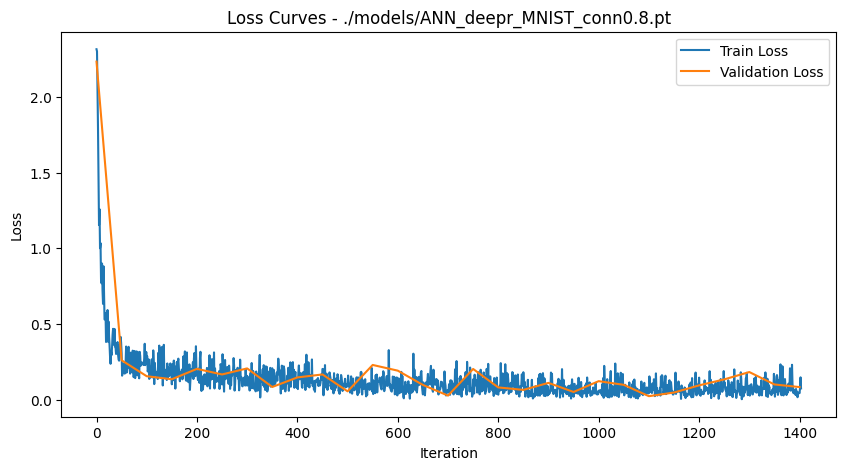

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 97.53%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.25
Validation accuracy: 9.38%
Training accuracy: 12.50%
----------------
Iteration: 50
Training loss: 0.38
Validation loss: 0.26
Validation accuracy: 92.97%
Training accuracy: 85.94%
----------------
Iteration: 100
Training loss: 0.16
Validation loss: 0.14
Validation accuracy: 96.88%
Training accuracy: 92.97%
----------------
Iteration: 150
Training loss: 0.14
Validation loss: 0.16
Validation accuracy: 96.09%
Training accuracy: 96.09%
----------------
Iteration: 200
Training loss: 0.12
Validation loss: 0.20
Validation accuracy: 92.97%
Training accuracy: 96.88%
----------------
Iteration: 250
Training loss: 0.11
Validation loss: 0.12
Validation accuracy: 95.31%
Training accuracy: 96.88%
----------------
Iteration: 300
Training loss: 0.25
Validation loss: 0.07
Validation accuracy: 97.66%
Training accuracy: 92.97%
----------------
Iteration: 350
Training loss: 0.12
Validation loss: 0.14
Validation accuracy: 96.09%
Training accuracy: 96.0

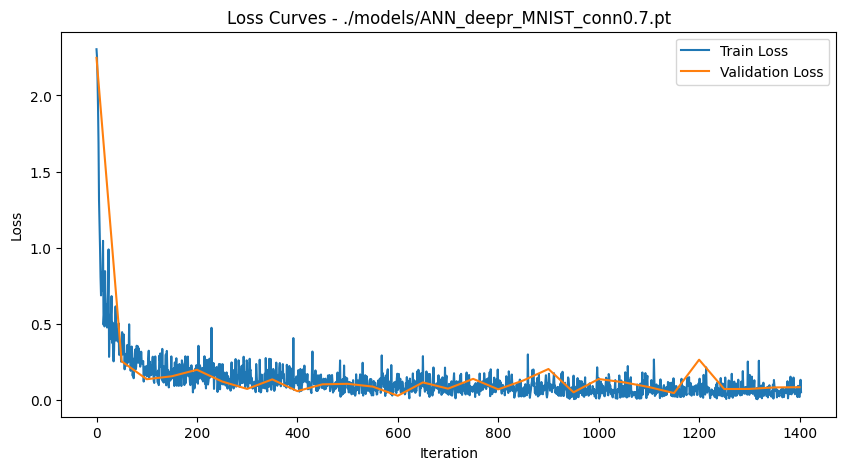

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 96.95%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.26
Validation accuracy: 16.41%
Training accuracy: 10.94%
----------------
Iteration: 50
Training loss: 0.34
Validation loss: 0.18
Validation accuracy: 94.53%
Training accuracy: 91.41%
----------------
Iteration: 100
Training loss: 0.28
Validation loss: 0.16
Validation accuracy: 93.75%
Training accuracy: 88.28%
----------------
Iteration: 150
Training loss: 0.26
Validation loss: 0.27
Validation accuracy: 88.28%
Training accuracy: 92.19%
----------------
Iteration: 200
Training loss: 0.10
Validation loss: 0.13
Validation accuracy: 94.53%
Training accuracy: 97.66%
----------------
Iteration: 250
Training loss: 0.31
Validation loss: 0.13
Validation accuracy: 96.09%
Training accuracy: 91.41%
----------------
Iteration: 300
Training loss: 0.16
Validation loss: 0.07
Validation accuracy: 96.88%
Training accuracy: 96.09%
----------------
Iteration: 350
Training loss: 0.18
Validation loss: 0.05
Validation accuracy: 97.66%
Training accuracy: 96.

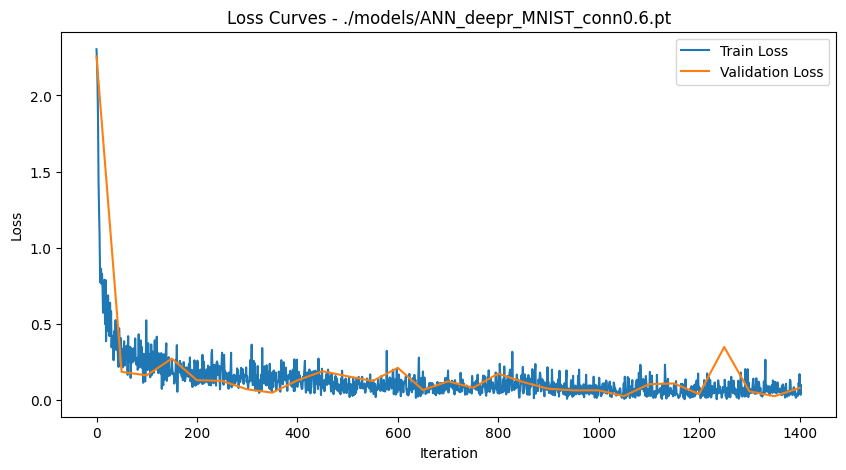

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 97.79%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.26
Validation accuracy: 14.84%
Training accuracy: 9.38%
----------------
Iteration: 50
Training loss: 0.44
Validation loss: 0.25
Validation accuracy: 90.62%
Training accuracy: 85.94%
----------------
Iteration: 100
Training loss: 0.19
Validation loss: 0.14
Validation accuracy: 95.31%
Training accuracy: 91.41%
----------------
Iteration: 150
Training loss: 0.24
Validation loss: 0.23
Validation accuracy: 92.97%
Training accuracy: 91.41%
----------------
Iteration: 200
Training loss: 0.16
Validation loss: 0.22
Validation accuracy: 92.19%
Training accuracy: 95.31%
----------------
Iteration: 250
Training loss: 0.09
Validation loss: 0.23
Validation accuracy: 89.06%
Training accuracy: 96.88%
----------------
Iteration: 300
Training loss: 0.22
Validation loss: 0.11
Validation accuracy: 96.09%
Training accuracy: 95.31%
----------------
Iteration: 350
Training loss: 0.07
Validation loss: 0.10
Validation accuracy: 95.31%
Training accuracy: 97.6

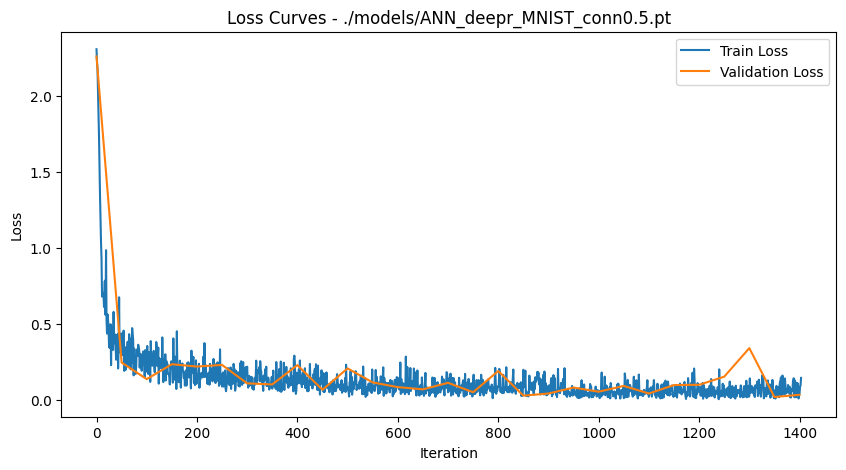

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 97.47%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.28
Validation accuracy: 9.38%
Training accuracy: 10.16%
----------------
Iteration: 50
Training loss: 0.43
Validation loss: 0.26
Validation accuracy: 92.97%
Training accuracy: 87.50%
----------------
Iteration: 100
Training loss: 0.24
Validation loss: 0.19
Validation accuracy: 94.53%
Training accuracy: 92.97%
----------------
Iteration: 150
Training loss: 0.20
Validation loss: 0.25
Validation accuracy: 92.19%
Training accuracy: 95.31%
----------------
Iteration: 200
Training loss: 0.29
Validation loss: 0.13
Validation accuracy: 96.88%
Training accuracy: 92.19%
----------------
Iteration: 250
Training loss: 0.27
Validation loss: 0.25
Validation accuracy: 92.19%
Training accuracy: 90.62%
----------------
Iteration: 300
Training loss: 0.21
Validation loss: 0.15
Validation accuracy: 95.31%
Training accuracy: 94.53%
----------------
Iteration: 350
Training loss: 0.09
Validation loss: 0.15
Validation accuracy: 96.09%
Training accuracy: 96.8

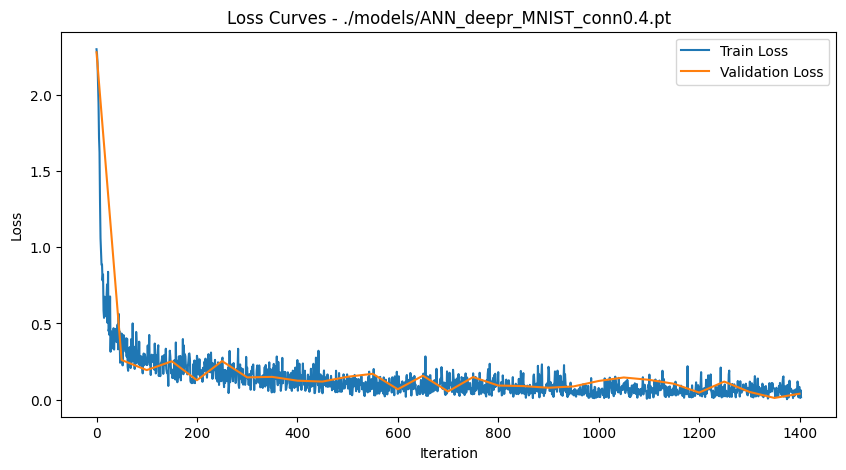

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 97.67%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.29
Validation accuracy: 9.38%
Training accuracy: 10.94%
----------------
Iteration: 50
Training loss: 0.38
Validation loss: 0.28
Validation accuracy: 89.84%
Training accuracy: 89.06%
----------------
Iteration: 100
Training loss: 0.29
Validation loss: 0.26
Validation accuracy: 89.06%
Training accuracy: 89.06%
----------------
Iteration: 150
Training loss: 0.20
Validation loss: 0.26
Validation accuracy: 92.97%
Training accuracy: 90.62%
----------------
Iteration: 200
Training loss: 0.34
Validation loss: 0.10
Validation accuracy: 96.09%
Training accuracy: 90.62%
----------------
Iteration: 250
Training loss: 0.23
Validation loss: 0.14
Validation accuracy: 94.53%
Training accuracy: 91.41%
----------------
Iteration: 300
Training loss: 0.21
Validation loss: 0.17
Validation accuracy: 94.53%
Training accuracy: 92.97%
----------------
Iteration: 350
Training loss: 0.20
Validation loss: 0.11
Validation accuracy: 96.09%
Training accuracy: 92.9

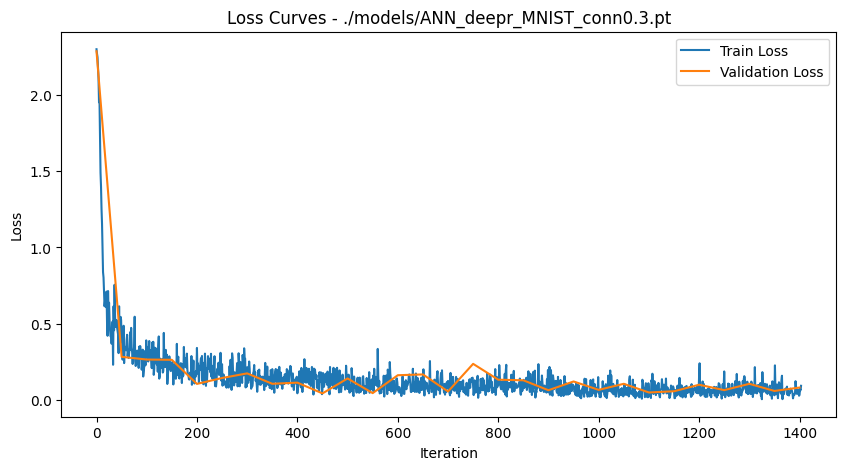

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 97.04%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.81%
Training accuracy: 14.06%
----------------
Iteration: 50
Training loss: 0.43
Validation loss: 0.40
Validation accuracy: 87.50%
Training accuracy: 86.72%
----------------
Iteration: 100
Training loss: 0.30
Validation loss: 0.37
Validation accuracy: 89.06%
Training accuracy: 90.62%
----------------
Iteration: 150
Training loss: 0.28
Validation loss: 0.19
Validation accuracy: 93.75%
Training accuracy: 90.62%
----------------
Iteration: 200
Training loss: 0.20
Validation loss: 0.16
Validation accuracy: 96.09%
Training accuracy: 92.19%
----------------
Iteration: 250
Training loss: 0.38
Validation loss: 0.11
Validation accuracy: 96.88%
Training accuracy: 89.84%
----------------
Iteration: 300
Training loss: 0.27
Validation loss: 0.17
Validation accuracy: 96.09%
Training accuracy: 91.41%
----------------
Iteration: 350
Training loss: 0.29
Validation loss: 0.09
Validation accuracy: 98.44%
Training accuracy: 89.8

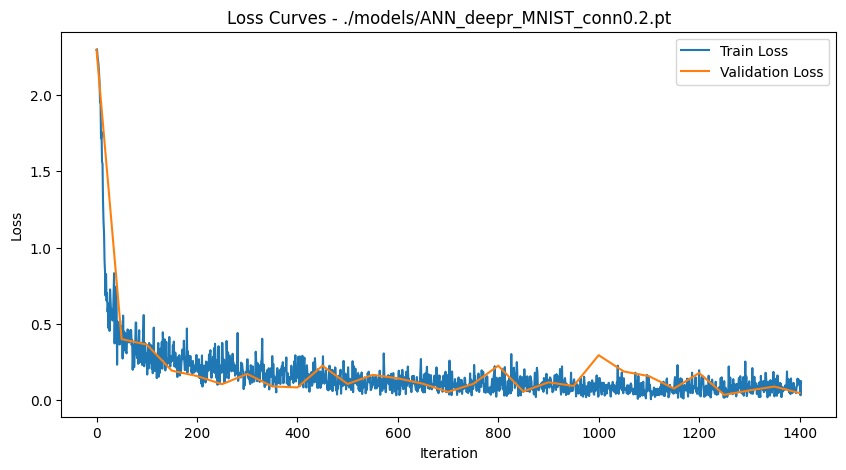

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 97.19%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.31
Validation loss: 2.30
Validation accuracy: 7.03%
Training accuracy: 7.03%
----------------
Iteration: 50
Training loss: 0.42
Validation loss: 0.55
Validation accuracy: 86.72%
Training accuracy: 85.94%
----------------
Iteration: 100
Training loss: 0.33
Validation loss: 0.30
Validation accuracy: 92.97%
Training accuracy: 89.84%
----------------
Iteration: 150
Training loss: 0.30
Validation loss: 0.17
Validation accuracy: 96.88%
Training accuracy: 92.19%
----------------
Iteration: 200
Training loss: 0.23
Validation loss: 0.18
Validation accuracy: 95.31%
Training accuracy: 92.97%
----------------
Iteration: 250
Training loss: 0.34
Validation loss: 0.14
Validation accuracy: 96.09%
Training accuracy: 90.62%
----------------
Iteration: 300
Training loss: 0.25
Validation loss: 0.22
Validation accuracy: 94.53%
Training accuracy: 91.41%
----------------
Iteration: 350
Training loss: 0.19
Validation loss: 0.15
Validation accuracy: 95.31%
Training accuracy: 92.19

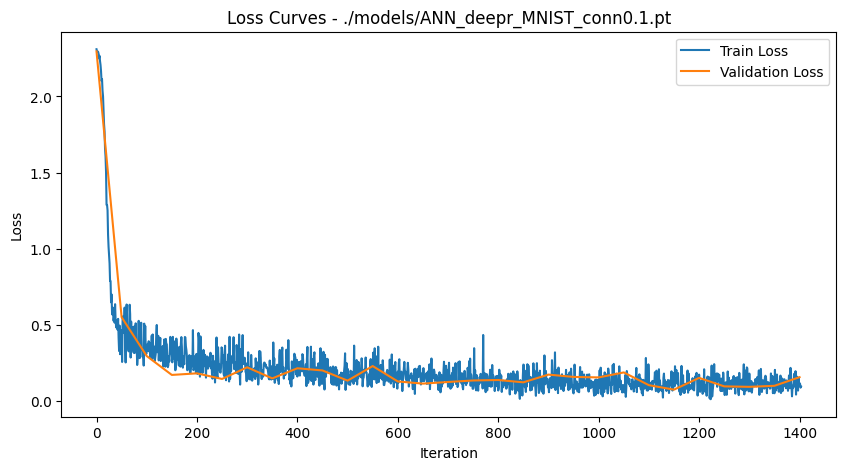

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 96.59%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 11.72%
Training accuracy: 10.94%
----------------
Iteration: 50
Training loss: 0.49
Validation loss: 0.31
Validation accuracy: 89.06%
Training accuracy: 86.72%
----------------
Iteration: 100
Training loss: 0.29
Validation loss: 0.56
Validation accuracy: 79.69%
Training accuracy: 90.62%
----------------
Iteration: 150
Training loss: 0.33
Validation loss: 0.18
Validation accuracy: 92.97%
Training accuracy: 90.62%
----------------
Iteration: 200
Training loss: 0.32
Validation loss: 0.13
Validation accuracy: 97.66%
Training accuracy: 89.84%
----------------
Iteration: 250
Training loss: 0.22
Validation loss: 0.16
Validation accuracy: 94.53%
Training accuracy: 95.31%
----------------
Iteration: 300
Training loss: 0.30
Validation loss: 0.16
Validation accuracy: 96.09%
Training accuracy: 92.97%
----------------
Iteration: 350
Training loss: 0.20
Validation loss: 0.25
Validation accuracy: 93.75%
Training accuracy: 92.

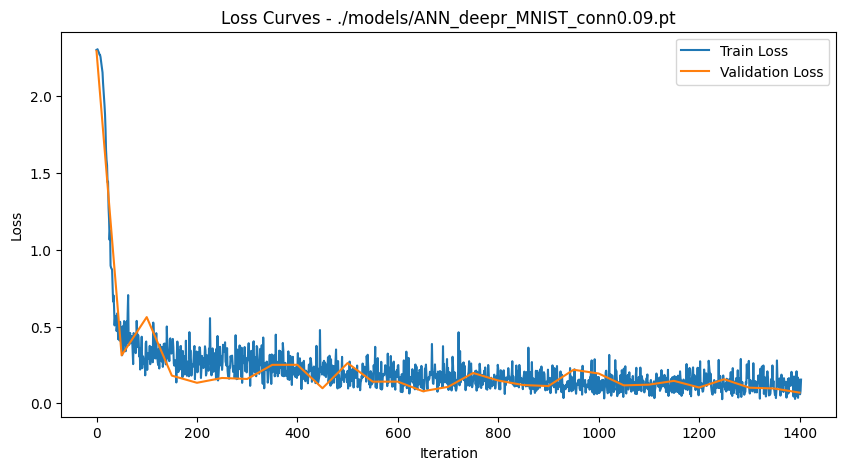

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 96.30%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.31
Validation loss: 2.31
Validation accuracy: 10.94%
Training accuracy: 11.72%
----------------
Iteration: 50
Training loss: 0.48
Validation loss: 0.36
Validation accuracy: 90.62%
Training accuracy: 85.94%
----------------
Iteration: 100
Training loss: 0.29
Validation loss: 0.42
Validation accuracy: 91.41%
Training accuracy: 92.97%
----------------
Iteration: 150
Training loss: 0.48
Validation loss: 0.24
Validation accuracy: 92.19%
Training accuracy: 85.94%
----------------
Iteration: 200
Training loss: 0.24
Validation loss: 0.26
Validation accuracy: 93.75%
Training accuracy: 92.19%
----------------
Iteration: 250
Training loss: 0.28
Validation loss: 0.34
Validation accuracy: 91.41%
Training accuracy: 90.62%
----------------
Iteration: 300
Training loss: 0.30
Validation loss: 0.14
Validation accuracy: 96.09%
Training accuracy: 89.84%
----------------
Iteration: 350
Training loss: 0.19
Validation loss: 0.27
Validation accuracy: 90.62%
Training accuracy: 92.

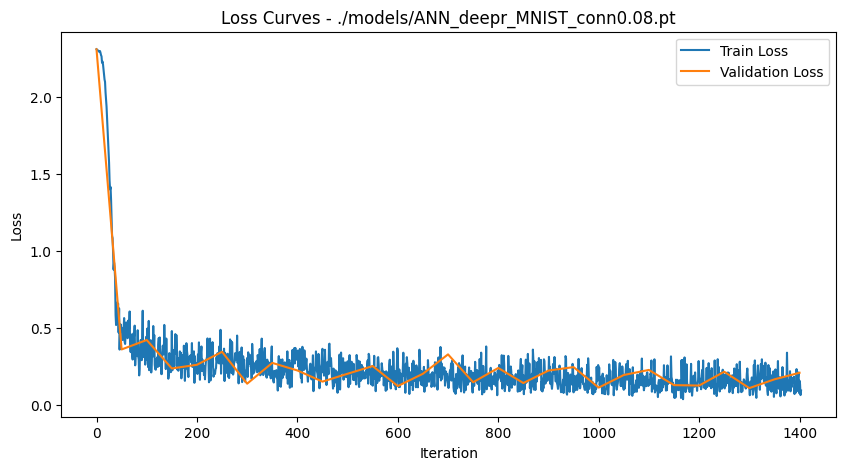

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 95.63%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.29
Validation accuracy: 11.72%
Training accuracy: 10.16%
----------------
Iteration: 50
Training loss: 0.42
Validation loss: 0.44
Validation accuracy: 86.72%
Training accuracy: 86.72%
----------------
Iteration: 100
Training loss: 0.41
Validation loss: 0.28
Validation accuracy: 93.75%
Training accuracy: 88.28%
----------------
Iteration: 150
Training loss: 0.35
Validation loss: 0.40
Validation accuracy: 89.84%
Training accuracy: 90.62%
----------------
Iteration: 200
Training loss: 0.30
Validation loss: 0.43
Validation accuracy: 89.06%
Training accuracy: 93.75%
----------------
Iteration: 250
Training loss: 0.25
Validation loss: 0.39
Validation accuracy: 87.50%
Training accuracy: 92.19%
----------------
Iteration: 300
Training loss: 0.40
Validation loss: 0.38
Validation accuracy: 90.62%
Training accuracy: 89.84%
----------------
Iteration: 350
Training loss: 0.16
Validation loss: 0.31
Validation accuracy: 92.97%
Training accuracy: 94.

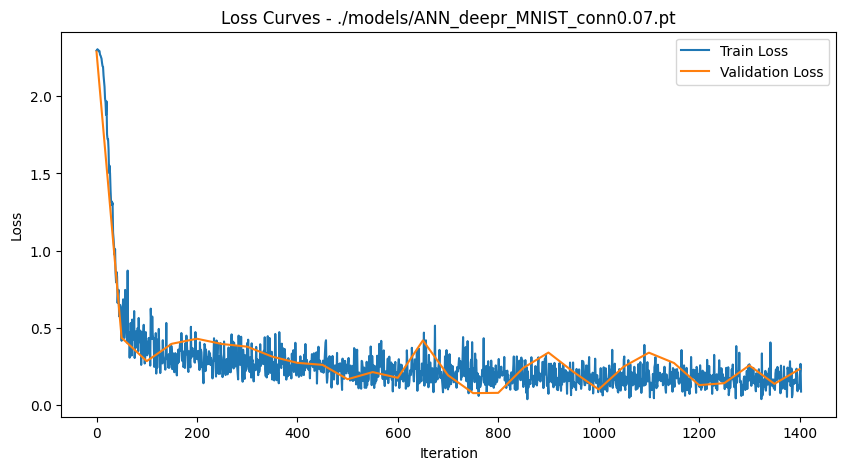

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 94.97%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.31
Validation loss: 2.31
Validation accuracy: 8.59%
Training accuracy: 4.69%
----------------
Iteration: 50
Training loss: 0.68
Validation loss: 0.73
Validation accuracy: 79.69%
Training accuracy: 85.16%
----------------
Iteration: 100
Training loss: 0.45
Validation loss: 0.48
Validation accuracy: 86.72%
Training accuracy: 87.50%
----------------
Iteration: 150
Training loss: 0.42
Validation loss: 0.36
Validation accuracy: 89.06%
Training accuracy: 88.28%
----------------
Iteration: 200
Training loss: 0.26
Validation loss: 0.58
Validation accuracy: 85.94%
Training accuracy: 90.62%
----------------
Iteration: 250
Training loss: 0.45
Validation loss: 0.33
Validation accuracy: 93.75%
Training accuracy: 90.62%
----------------
Iteration: 300
Training loss: 0.28
Validation loss: 0.21
Validation accuracy: 93.75%
Training accuracy: 92.97%
----------------
Iteration: 350
Training loss: 0.27
Validation loss: 0.38
Validation accuracy: 89.06%
Training accuracy: 94.53

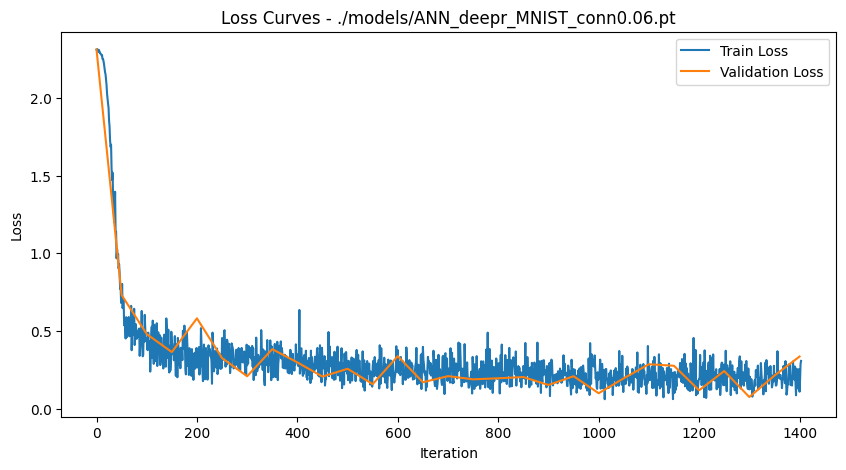

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 94.03%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.31
Validation loss: 2.30
Validation accuracy: 11.72%
Training accuracy: 8.59%
----------------
Iteration: 50
Training loss: 0.70
Validation loss: 0.59
Validation accuracy: 85.94%
Training accuracy: 81.25%
----------------
Iteration: 100
Training loss: 0.45
Validation loss: 0.44
Validation accuracy: 88.28%
Training accuracy: 82.81%
----------------
Iteration: 150
Training loss: 0.46
Validation loss: 0.22
Validation accuracy: 97.66%
Training accuracy: 89.06%
----------------
Iteration: 200
Training loss: 0.30
Validation loss: 0.34
Validation accuracy: 88.28%
Training accuracy: 90.62%
----------------
Iteration: 250
Training loss: 0.28
Validation loss: 0.32
Validation accuracy: 89.84%
Training accuracy: 90.62%
----------------
Iteration: 300
Training loss: 0.30
Validation loss: 0.33
Validation accuracy: 92.19%
Training accuracy: 89.06%
----------------
Iteration: 350
Training loss: 0.28
Validation loss: 0.21
Validation accuracy: 90.62%
Training accuracy: 91.4

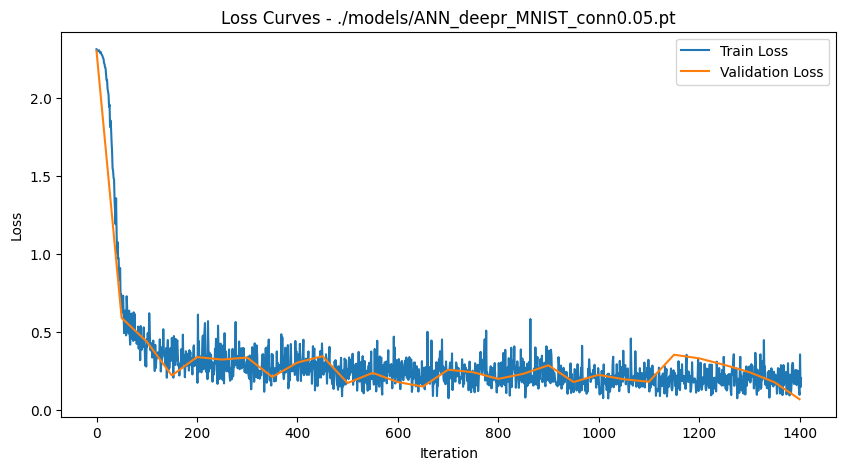

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 94.07%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 16.41%
Training accuracy: 11.72%
----------------
Iteration: 50
Training loss: 1.53
Validation loss: 1.53
Validation accuracy: 43.75%
Training accuracy: 50.00%
----------------
Iteration: 100
Training loss: 1.04
Validation loss: 1.10
Validation accuracy: 69.53%
Training accuracy: 68.75%
----------------
Iteration: 150
Training loss: 0.76
Validation loss: 0.56
Validation accuracy: 82.81%
Training accuracy: 75.78%
----------------
Iteration: 200
Training loss: 0.53
Validation loss: 0.65
Validation accuracy: 82.03%
Training accuracy: 85.94%
----------------
Iteration: 250
Training loss: 0.65
Validation loss: 0.39
Validation accuracy: 90.62%
Training accuracy: 80.47%
----------------
Iteration: 300
Training loss: 0.63
Validation loss: 0.32
Validation accuracy: 89.84%
Training accuracy: 86.72%
----------------
Iteration: 350
Training loss: 0.48
Validation loss: 0.39
Validation accuracy: 89.84%
Training accuracy: 85.

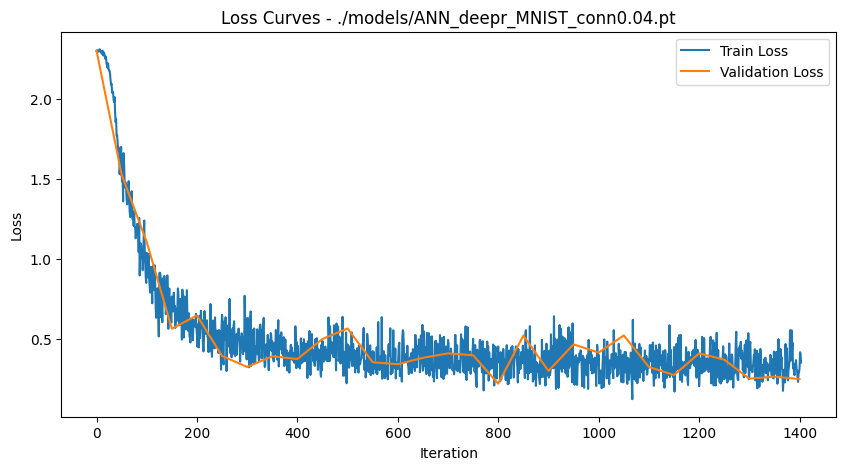

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 89.60%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 12.50%
Training accuracy: 8.59%
----------------
Iteration: 50
Training loss: 1.79
Validation loss: 1.62
Validation accuracy: 58.59%
Training accuracy: 35.94%
----------------
Iteration: 100
Training loss: 1.14
Validation loss: 1.01
Validation accuracy: 67.97%
Training accuracy: 67.19%
----------------
Iteration: 150
Training loss: 0.81
Validation loss: 0.84
Validation accuracy: 75.78%
Training accuracy: 76.56%
----------------
Iteration: 200
Training loss: 0.88
Validation loss: 0.92
Validation accuracy: 65.62%
Training accuracy: 68.75%
----------------
Iteration: 250
Training loss: 0.59
Validation loss: 0.65
Validation accuracy: 77.34%
Training accuracy: 79.69%
----------------
Iteration: 300
Training loss: 0.85
Validation loss: 0.65
Validation accuracy: 82.03%
Training accuracy: 72.66%
----------------
Iteration: 350
Training loss: 0.79
Validation loss: 0.70
Validation accuracy: 75.00%
Training accuracy: 78.9

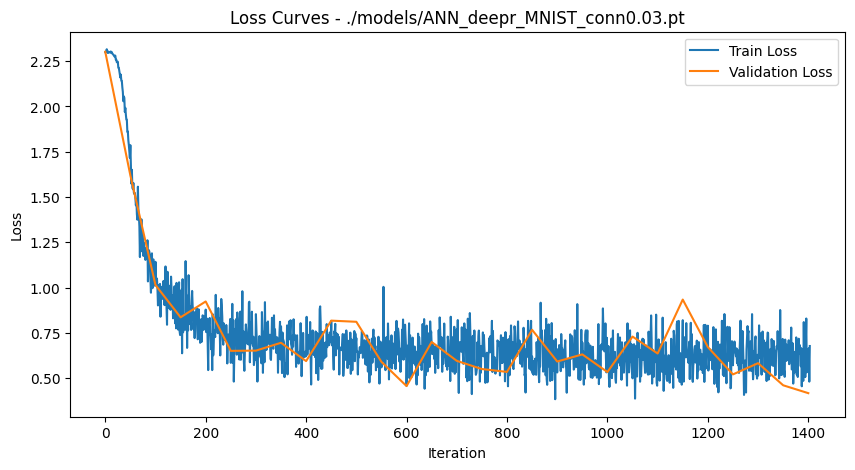

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 78.97%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.31
Validation accuracy: 8.59%
Training accuracy: 7.03%
----------------
Iteration: 50
Training loss: 2.16
Validation loss: 2.11
Validation accuracy: 26.56%
Training accuracy: 28.12%
----------------
Iteration: 100
Training loss: 1.70
Validation loss: 1.72
Validation accuracy: 50.00%
Training accuracy: 50.78%
----------------
Iteration: 150
Training loss: 1.60
Validation loss: 1.57
Validation accuracy: 48.44%
Training accuracy: 47.66%
----------------
Iteration: 200
Training loss: 1.27
Validation loss: 1.51
Validation accuracy: 56.25%
Training accuracy: 57.81%
----------------
Iteration: 250
Training loss: 1.22
Validation loss: 1.26
Validation accuracy: 58.59%
Training accuracy: 63.28%
----------------
Iteration: 300
Training loss: 1.28
Validation loss: 1.04
Validation accuracy: 67.19%
Training accuracy: 55.47%
----------------
Iteration: 350
Training loss: 1.30
Validation loss: 1.08
Validation accuracy: 60.94%
Training accuracy: 51.56

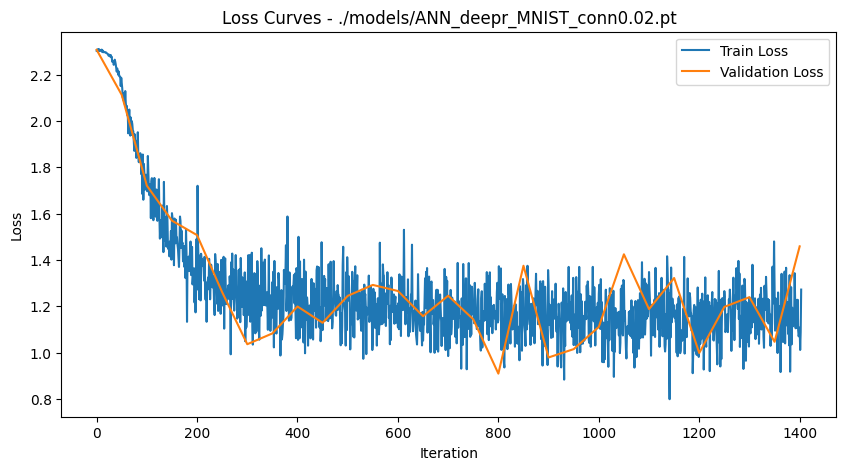

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 59.39%


Training progress::   0%|          | 0/1404 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.31
Validation loss: 2.30
Validation accuracy: 7.81%
Training accuracy: 6.25%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 12.50%
Training accuracy: 8.59%
----------------
Iteration: 100
Training loss: 2.26
Validation loss: 2.26
Validation accuracy: 9.38%
Training accuracy: 14.06%
----------------
Iteration: 150
Training loss: 2.22
Validation loss: 2.24
Validation accuracy: 15.62%
Training accuracy: 21.09%
----------------
Iteration: 200
Training loss: 2.26
Validation loss: 2.21
Validation accuracy: 13.28%
Training accuracy: 8.59%
----------------
Iteration: 250
Training loss: 2.22
Validation loss: 2.19
Validation accuracy: 11.72%
Training accuracy: 8.59%
----------------
Iteration: 300
Training loss: 2.24
Validation loss: 2.22
Validation accuracy: 14.84%
Training accuracy: 11.72%
----------------
Iteration: 350
Training loss: 2.24
Validation loss: 2.22
Validation accuracy: 11.72%
Training accuracy: 10.16%
--

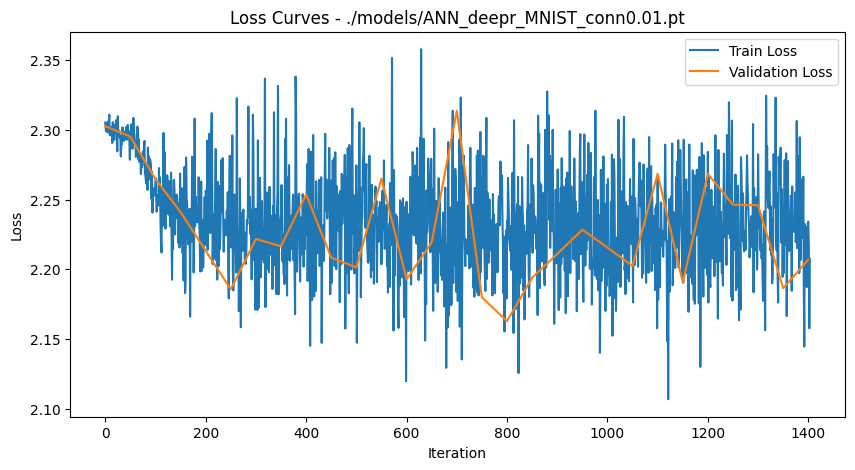

Testing progress::   0%|          | 0/78 [00:00<?, ?it/s]

Test Accuracy: 11.23%


TypeError: file must have a 'write' attribute

In [2]:
connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]

accuracies = []

for c in connectivities:
    model_path = "./models/ANN_deepr_MNIST_conn"+str(c)+".pt"
    net = Net(c)
    net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,lr=lr,epochs=3,iterations=None,deepr=True,device=device)
    a = test_stats(net,test_loader=test_loader,device=device)
    accuracies.append(a)

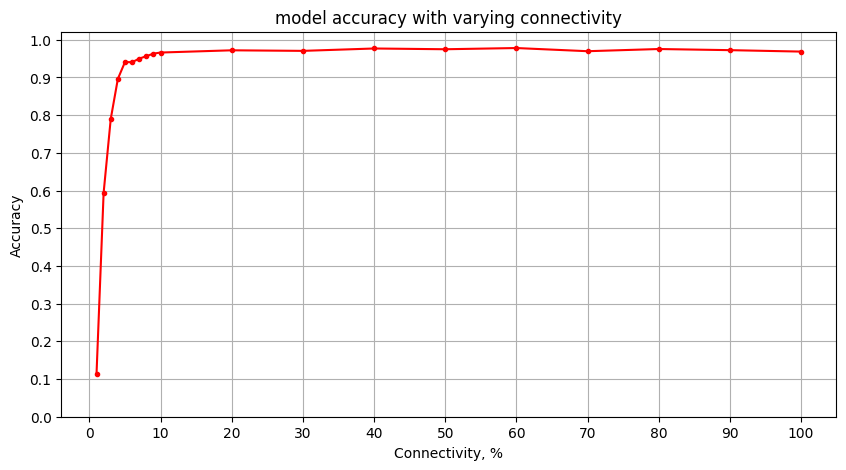

In [6]:
with open("./pickles/torch_MNIST_deepr_accuracies", "wb") as f:
    pickle.dump(accuracies,f)
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot([c*100 for c in connectivities],accuracies,'.r-')
plt.title("model accuracy with varying connectivity")
plt.xlabel("Connectivity, %")
plt.ylabel("Accuracy")
plt.xticks(range(0,101,10))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.show()


In [ ]:
net = Net()
net.load_state_dict(torch.load(model_path))

print(torch.sum(net.linears[2].weight!=0)/torch.numel(net.linears[2].weight))
#sparsity of final layer below 5%?

print(torch.sum( torch.abs(net.deepr.weightSignMasks[2]))/torch.numel(net.deepr.weightSignMasks[2]))

flip0 = torch.sum(torch.abs(net.deepr.flipTrack[0]),dim=0).view(28,28).cpu()
plt.imshow(flip0, cmap='gray', interpolation='nearest')

TypeError: Net.__init__() missing 1 required positional argument: 'connectivity'

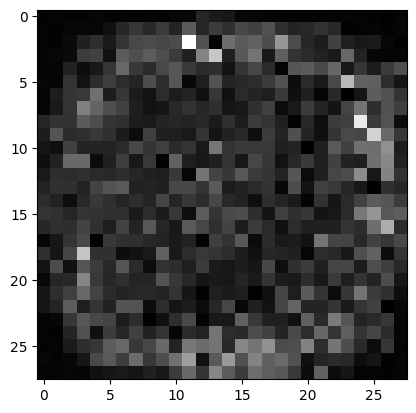

In [ ]:
weights0 = torch.abs(net.linears[0].weight.detach().cpu()).sum(dim=0).view(28,28)
plt.imshow(weights0, cmap='gray', interpolation='nearest')

mean:  tensor(0.1250) std:  tensor(0.3460)


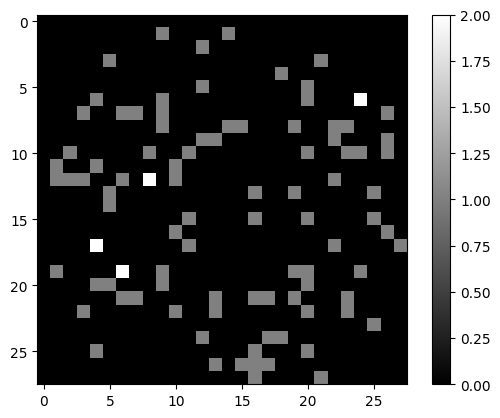

mean:  tensor(13.2385) std:  tensor(6.1310)


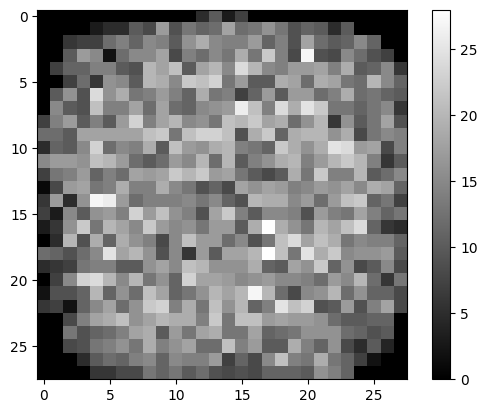

In [ ]:
### flip stats for active connections

#layer 1



flip_active0 = net.weightMasker.flipTrack[0] * torch.abs(net.weightMasker.weightSignMasks[0])
flip_active0 = flip_active0.cpu().abs().sum(dim=0).view(28,28)
print("mean: ",flip_active0.mean(),"std: ",flip_active0.std())
plt.imshow(flip_active0, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()


flip_active0 = net.weightMasker.flipTrack[0] * torch.abs((net.weightMasker.weightSignMasks[0]==0).to(torch.float))
flip_active0 = flip_active0.cpu().abs().sum(dim=0).view(28,28)
print("mean: ",flip_active0.mean(),"std: ",flip_active0.std())
plt.imshow(flip_active0, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

mean:  tensor(0.0100) std:  tensor(0.0997)


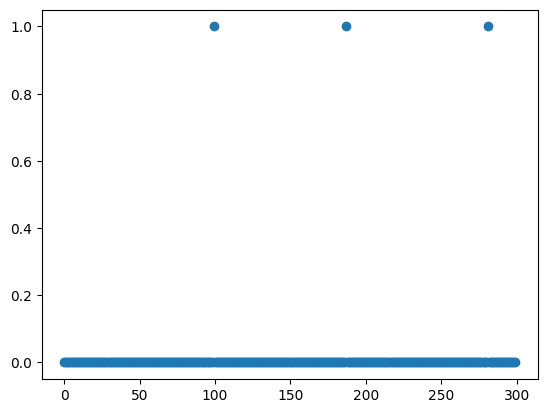

mean:  tensor(1.2100) std:  tensor(1.0816)


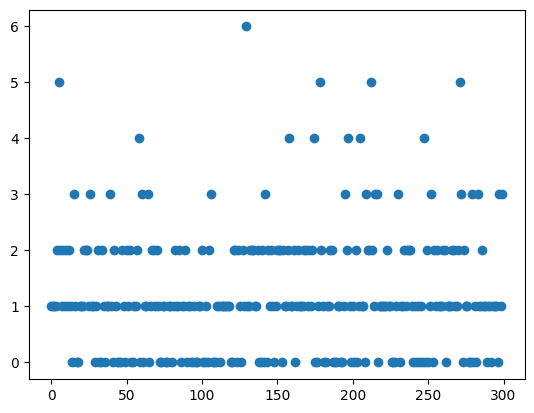

In [ ]:
### flip stats for active connections

#layer 2



flip_active0 = net.weightMasker.flipTrack[1] * torch.abs(net.weightMasker.weightSignMasks[1])
flip_active0 = flip_active0.cpu().abs().sum(0)
print("mean: ",flip_active0.mean(),"std: ",flip_active0.std())
plt.scatter(range(len(flip_active0)),flip_active0)
plt.show()


flip_active0 = net.weightMasker.flipTrack[1] * torch.abs((net.weightMasker.weightSignMasks[1]==0).to(torch.float))
flip_active0 = flip_active0.cpu().abs().sum(0)
print("mean: ",flip_active0.mean(),"std: ",flip_active0.std())
plt.scatter(range(len(flip_active0)),flip_active0)
plt.show()